### What's wrong with seq2seq model?

The seq2seq models is normally composed of an encoder-decoder architecture, where the encoder processes the input setence and encodes/compresses/summarizes the information into a context vector (called "thought vector") of a fixed length. This representation is expected to be a good summary of the entire input sequence. The decoder is then initialized with this context vector, using which it starts generating the transformed output.

A critical and apparent disadvantage of this fixed-length context vector design is hte incapability of the system to remember longer sequences. Often is has forgotten the earlier parts of the sequence once it has processed the entire the sequence. The attention mechanism was born to resolve this problem.

### Attention Mechanism

Attention 机制的引入就是为了解决此问题，Attention机制使得机器翻译中利用原始的sentence信息，减少信息损失。在解码层生成每个时刻的y都会利用$x_1,x_2,...$,而不再仅仅利用最后时刻的hidden state.同时注意力机制还能使翻译器zoom in or out(使用局部或全局信息)。

The below illustration shows how the prediction of words depends on two or more words in the sentence. In the follow gif, the links which are thin have a lower contribution to the prediction of a word while links that are thick have a higher contribution. We can observe that most of the predicted words in the target sequence depend on words after and before the correspinding word in the source sequence.

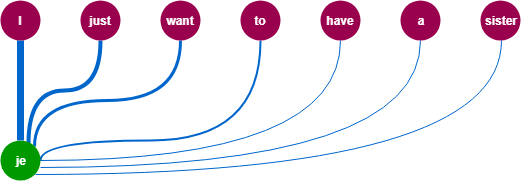

### The central idea behind Attention

Input sentence(English)=>"Rahul is a good boy"

Target sentence(Marathi)=>"राहुल चांगला मुलगा आहे"

The only change will be that instead of an LSTM layer that I used in my previous explanation, here I will use a GRU layer. The reason being that LSTM has two internal states (hidden state and cell state) and GRU has only one internal state (hidden state). This will help simplify the concept and explanation.

Recall the below diagram in which I summarized the entire process procedure of seq2seq modelling.

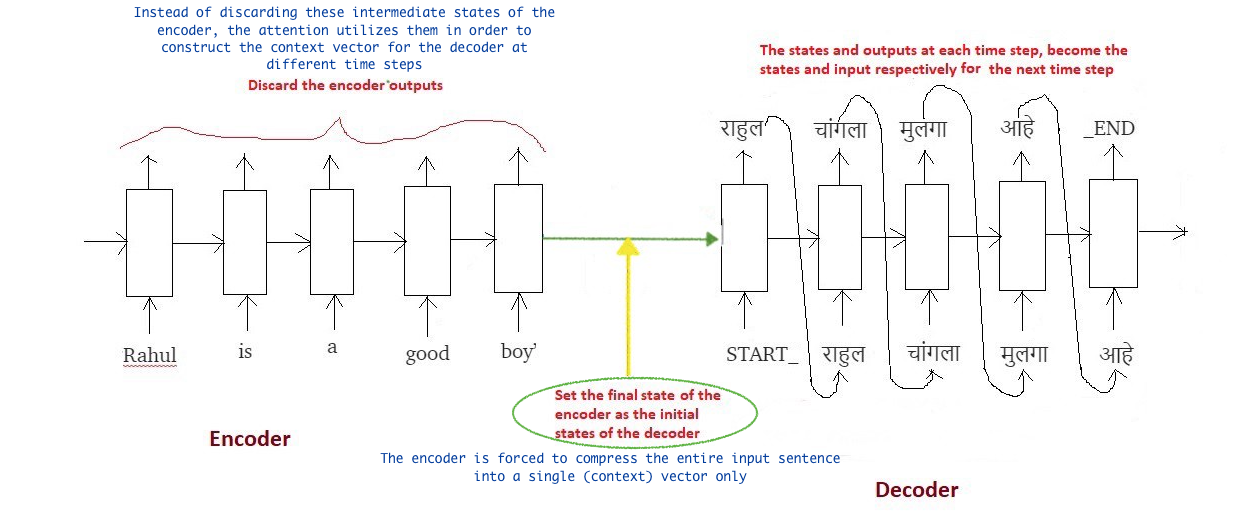

In the traditional seq2seq model, we discard all the internal states of the encoder and use only its final states (vector) to initialize the decoder. This technique works good for smaller sequence, however as the length of the sequence increase, a single vector becomes a bottleneck and it gets very difficult to summarize long sequences into a single vector. This observation was made empirically as it was noted that the performance of the system decreases drastically as the size of the sequence increases.

The central idea behind Attention is not to throw away those intermediate encoder states but to utilize all the states in order to construct the context vectors required b y the decoder to generate the output sequence.

### Why the name Attention?

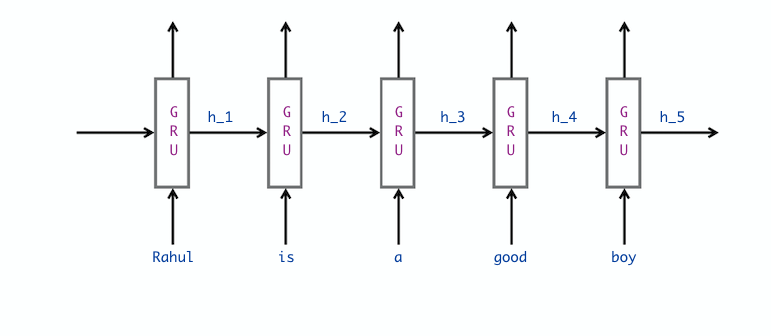

Recall that these states $(h_1 to h_5)$ are nothing but vectors of fixed length. To develop some intuition think of these states as vectors which store local information within the sequence. For example: 

$h_1$ stores the information present in the start of the sequence (words like "Rahul" and "is") while $h_5$ stores the information present in the later part of sequence (words like "good" and "boy");

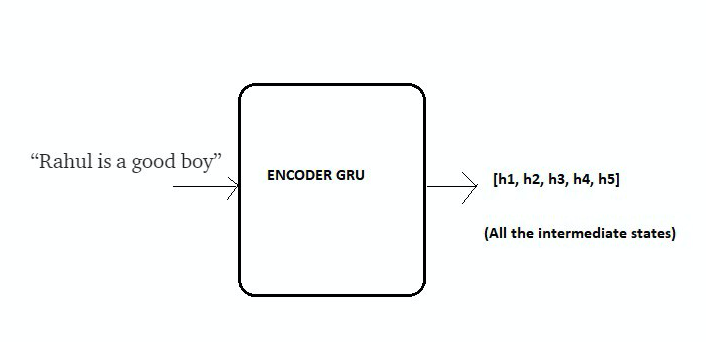

Now the idea is to utilize all of these local information collectively in order to decide the next sequence while decoding the target sentence.

Imagine you are translating “Rahul is a good boy” to “राहुल चांगला मुलगा आहे”. Ask yourself, how do you do it in your mind?

When you predict “राहुल”, its obvious that this name is the result of the word “Rahul” present in the input English sentence regardless of the rest of the sentence. We say that while predicting “राहुल”, we pay more attention to the word “Rahul” in the input sentence.

Similarly while predicting the word “चांगला”, we pay more attention to the word “good” in the input sentence.

Similarly while predicting the word “मुलगा”, we pay more attention to the word “boy” in the input sentence. And so on..

Hence the name “**ATTENTION**”.

As human beings we are quickly able to understand these mappings between different parts of the input sequence and corresponding parts of the output sequence. However its not that straight forward for artificial neural network to automatically detect these mappings.

Thus the Attention mechanism is developed to “learn” these **mappings** through Gradient Descent and Back-propagation.

### How does Attention work?

Let's get technical and dive into the nitty gritty of **Attention mechanism.**

#### Decoding at time step 1

Continuing the above example, let’s say we now want our decoder to start predicting the first word of the target sequence i.e. “राहुल”

At time step 1, we can break the entire process into five steps as below:

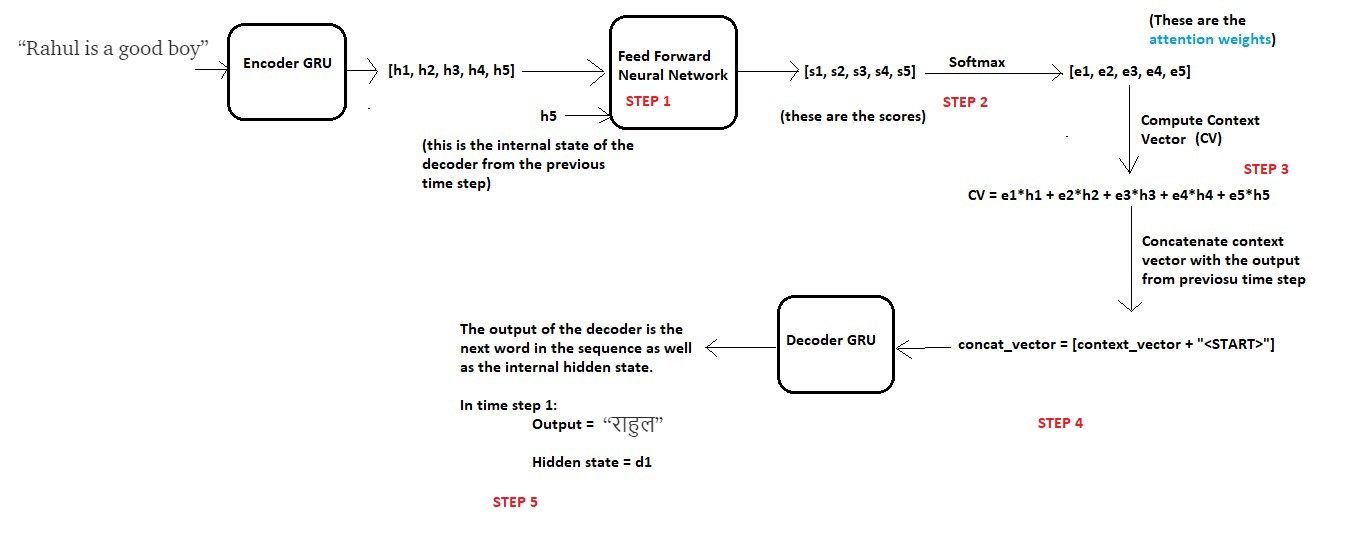

Before we start decoding, we first need to encode the input sequence into a set of internal states (in our case $h_1, h_2, h_3, h_4$ and $h_5$).

Now the hypothesis is that, the next word in the output sequence is dependent on the current state of the decoder (decoder is also a GRU) as well as on the hidden states of the encoder. Thus at each time step, we consider these two things and follow the below steps:

**Step1 -- Compute a score each encoder state**

Since we are predicting the first word itself, the decoder does not have any current internal state. For this reason, we will consider the last state of the encoder (i.e. h5) as the previous decoder state.

Now using these two components (all the encoder states and the current state of the decoder), we will train a simple feed forward neural network.

Why?

Recall we are trying to predict the first word in the target sequence i.e. “राहुल”. As per the idea behind attention, we do not need all the encoder states to predict this word, but we need those encoder states which store information about the word “Rahul” in the input sequence.

As discussed previously these intermediate encoder states store the local information of the input sequence. So it is highly likely that the information of the word “Rahul” will be present in the states, let’s say, $h_1$ and $h_2$.

Thus we want our decoder to pay more attention to the states h1 and h2 while paying less attention to the remaining states of the encoder.

For this reason we train a feed forward neural network which will **learn** to identify relevant encoder states by generating a high score for the states for which attention is to be paid while low score for the states which are to be ignored.

Let $s_1, s_2, s_3, s_4$ and $s_5$ be the scores generated for the states $h_1, h_2, h_3, h_4$ and $h_5$ correspondingly. Since we assumed that we need to pay more attention to the states $h_1$ and $h_2$ and ignore $h_3$, $h_4$ and $h_5$ in order to predict “राहुल”, we expect the above neural to generate scores such that $s_1$ and $s_2$ are high while $s_3$, $s_4$ and $s_5$ are relatively low.

**Step 2 -- Compute the attention weights**

Once these scores are generated, we apply a softmax on these scores to produce the attention weights $e_1$, $e_2$, $e_3$ ,$e_4$ and $e_5$ as shown above. The advantage of applying softmax is as below:

a) All the weights lie between 0 and 1, i.e., $0 ≤ e_1, e_2, e_3, e_4, e_5 ≤ 1$

b) All the weights sum to 1, i.e., $e_1+e_2+e_3+e_4+e_5 = 1$,Thus we get a nice probabilistic interpretation of the attention weights.In our case we would expect values like below: (just for intuition)

$e_1 = 0.75, e_2 = 0.2, e_3 = 0.02, e_4 = 0.02, e_5 = 0.01$

This means that while predicting the word “राहुल”, the decoder needs to put more attention on the states $h_1$ and $h_2$ (since values of $e_1$ and $e_2$ are high) while ignoring the states $h_3$, $h_4$ and $h_5$ (since the values of $e_3$, $e_4$ and $e_5$ are very small).

**Step 3 —- Compute the context vector**

Once we have computed the attention weights, we need to compute the context vector (thought vector) which will be used by the decoder in order to predict the next word in the sequence. Calculated as follows:

$context_vector = e_1 * h_1 + e_2 * h_2 + e_3 * h_3 + e_4 * h_4 + e_5 * h_5$

Clearly if the values of $e_1$ and $e_2$ are high and those of $e_3$, $e_4$ and $e_5$ are low then the context vector will contain more information from the states $h_1$ and $h_2$ and relatively less information from the states h3, h4 and $h_5$.

**Step 4 -- Concatenate context vector with output of previous time step**

Finally the decoder uses the below two input vectors to generate the next word in the sequence.

- The context vector

- The output word generated from the previous time step.

We simply concatenate these two vectors and feed the merged vector to the decoder. **Note that for the first time step, since there is no output from the previous time step, we use a special \<START\> token for this purpose.**

**Step 5 -— Decoder Output**

The decoder then generates the next word in the sequence (in this case, it is expected to generate “राहुल”) and along with the output, the decoder will also generate an internal hidden state, and lets call it as “d1”.

### Decoding at time step 2

Now in order to generate the next word “चांगला”, the decoder will repeat the same procedure which can be summarized in the below diagram:

The changes are highlighted in green circles

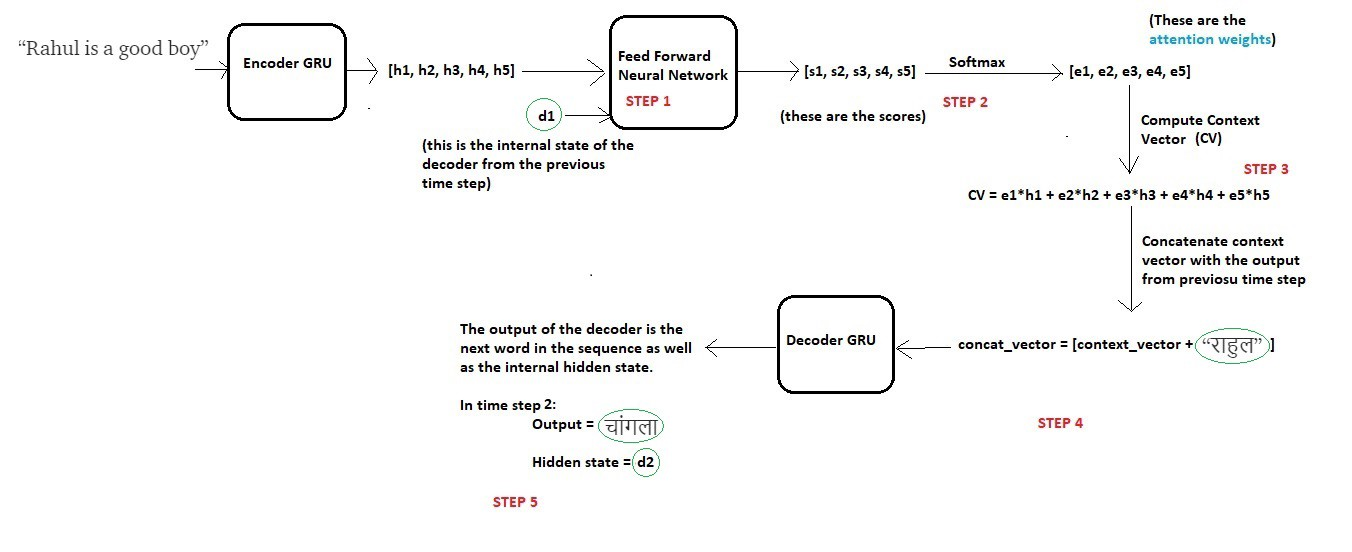

### Decoding at time step 3

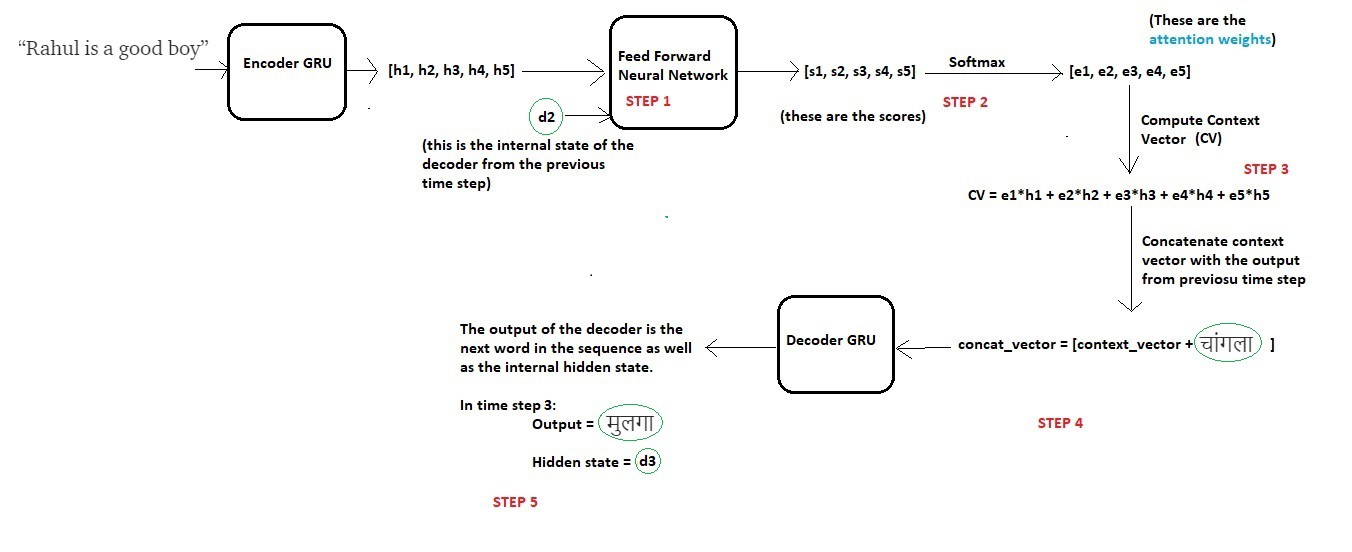

### Decoding at time step 4

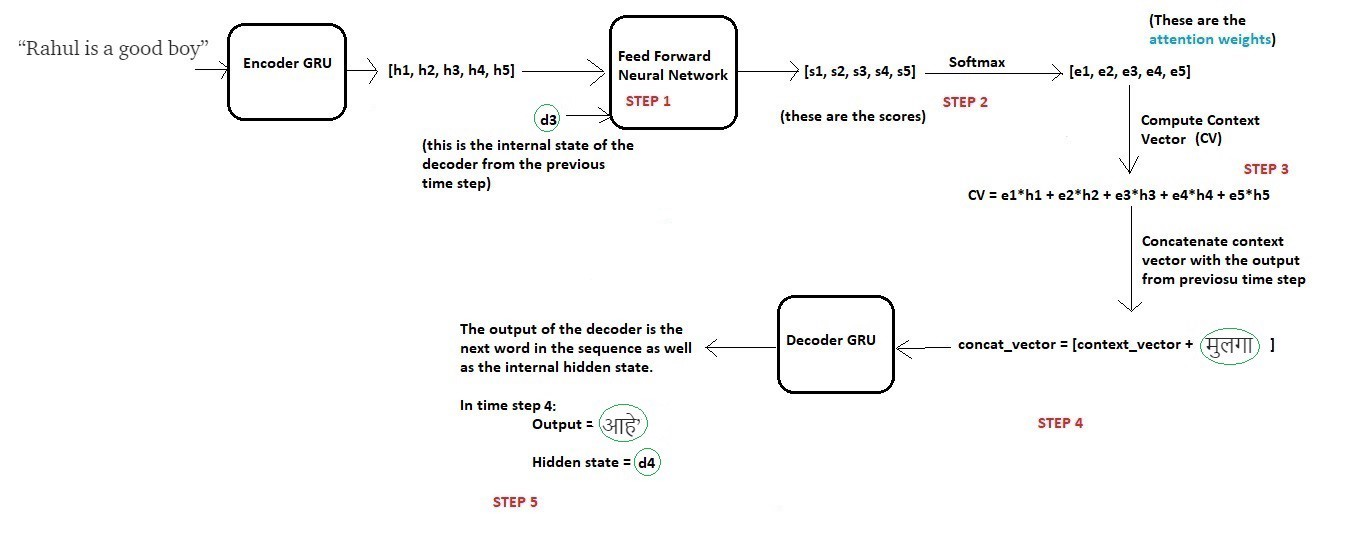

### Decoding at time step 5

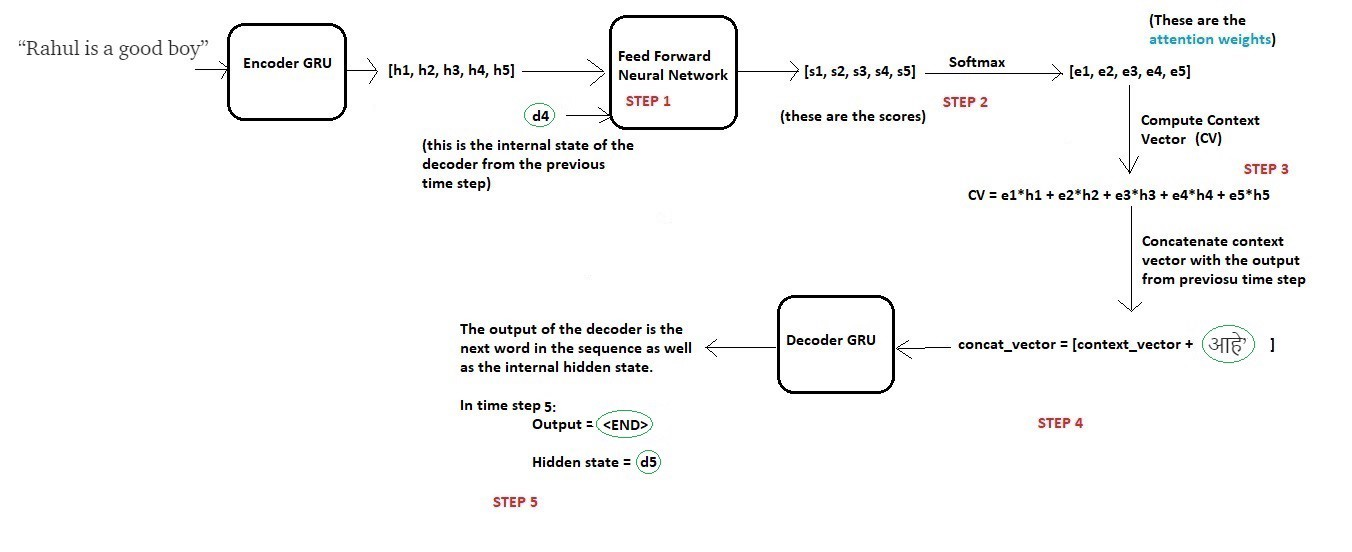


Once the decoder outputs the \<END\> token, we stop the generation process.

Note that unlike the fixed context vector used for all the decoder time steps in case of the traditional Seq2Seq models, here in case of Attention, we compute a separate context vector for each time step by computing the attention weights every time.

Thus using this mechanism our model is able to find interesting mappings between different parts of the input sequence and corresponding parts of the output sequence.

Note that during the training of the network, we use teacher forcing in order to input the actual word rather than the predicted word from the previous time step.

#### Disadvantage of the Attention mechanism 

It is a very time consuming and hard to parallelize system. To solve this problem, Google Brain came up with the “**Transformer Model**” which uses only Attention and gets rid of all the Convolutional and Recurrent Layers, thus making it highly parallelizable and compute efficient.

**Decoder**

定义每一个输出的预测单词$y_i$的条件概率分布为$p(y_i|\{y_1,...,y_{i-1}\},x)=g(y_{i-1},s_i,c_i)$,其中$g$是非线性函数，$y_{i-1}$是上一个单词，$s_i$是RNN当前的hidden state, $c_i$是当前的context vector. 那么$c_i$是怎么计算得来的呢？目前常用的两种方法BahdanauAttention和LuongAttention.

## Bahdanau Attention

https://arxiv.org/pdf/1409.0473.pdf

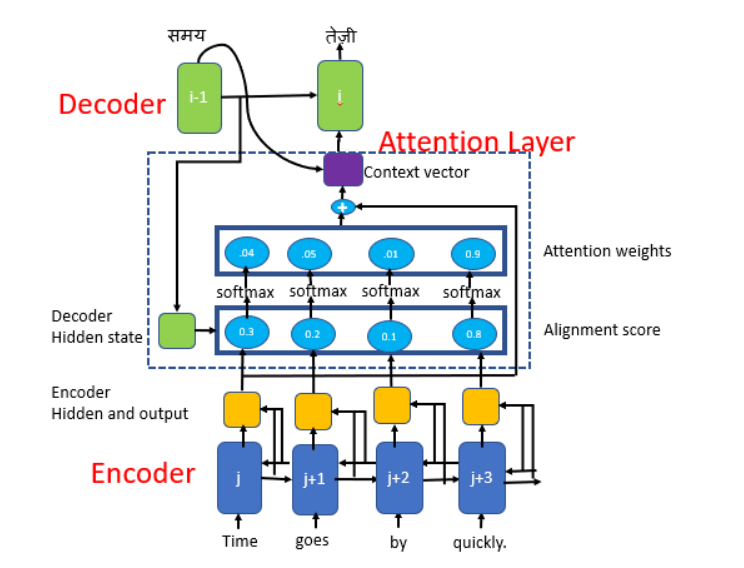

Bahdanau Attention is also known as Additive attention as it performs a linear combination of encoder states and the decoder states. 

The entire step-by-step process of applying Attention in Bahdanau’s paper is as follows:

### 1. Generating the Encoder Hidden States

We can use any variants of RNN such as LSTM or GRU to encode the input sequence. A hidden state will be produced by each cell for each input passed. Now, unlike the seq2seq model. we pass all the hidden state produced by all RNN units to the next steps.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EncoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1, drop_prob=0):
        super(EncoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers, dropout=drop_prob, batch_first=True)
        
    def forward(self, inputs, hidden):
        # Embed input words
        embedded = self.embedding(inputs)
        # Pass the embedded word vectors into LSTM and return all outputs
        output, hidden = self.lstm(embedded, hidden)
        return output, hidden
    
    def init_hidden(self, batch_size=1):
        return (torch.zeros(self.n_layers, batch_size, self.hidden_size, device=device),
                torch.zeros(self.n_layers, batch_size, self.hidden_size, device=device))

### 2. Calculating Alignment Scores

After obtaining all of our encoder outputs, we can start **using the decoder to produce outputs**. At each time step of the decoder, we have to **calculate the alignment score of each encoder output with respect to the decoder input and hidden state at that time step**. The alignment score is the essence of the Attention mechanism, as it quantifies(量化) the amount of "Attention" the decoder will place on each of the encoder outputs when producing the next output.

Fig. The encoder-decoder model with additive attention mechanism in Bahdanau et al., 2015.

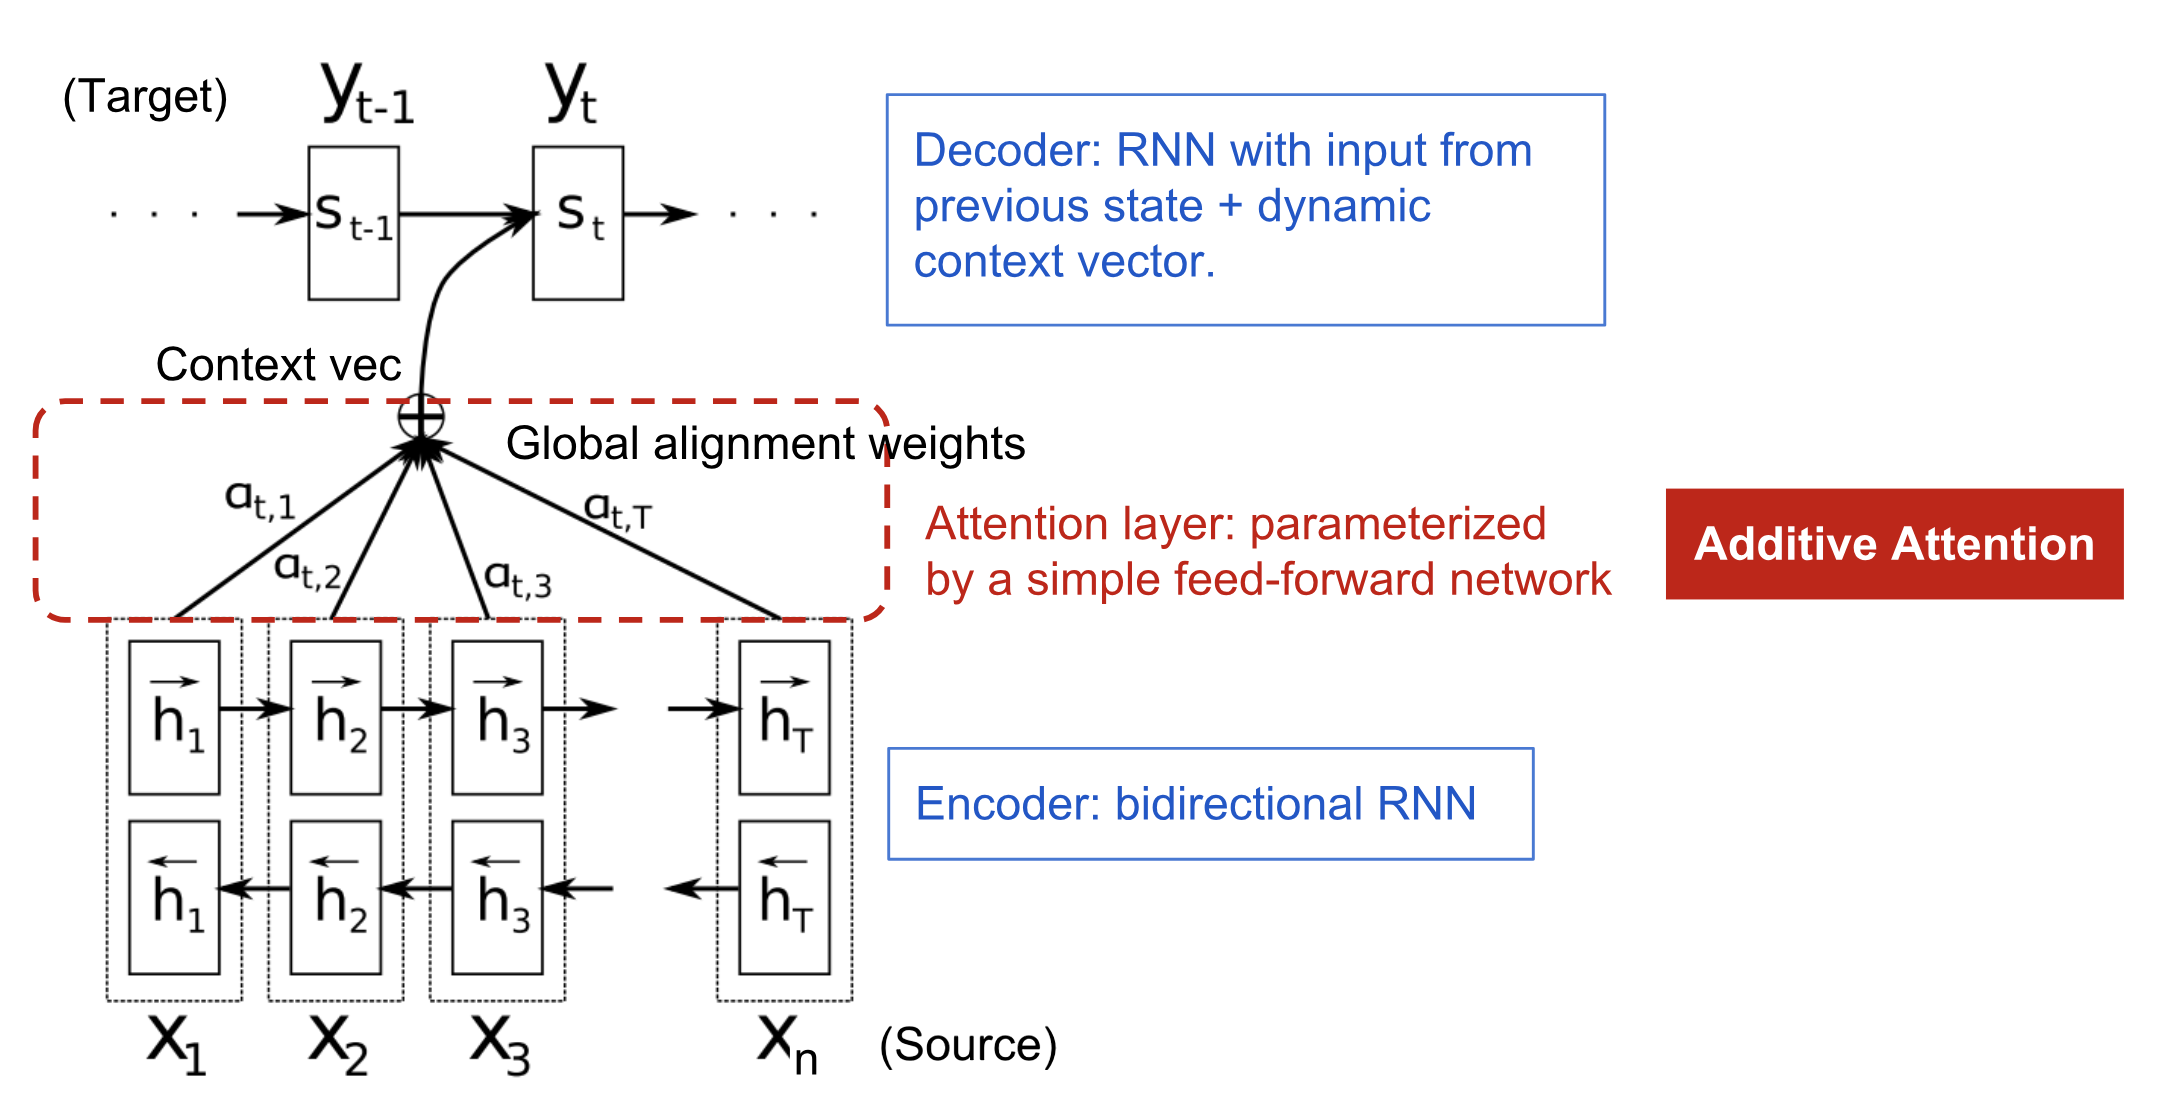

The alignment model assigns a score $\alpha_{t,i}$ to the pair of input at position i and output at position t, $(y_t,x_i)$, based on how well they match. The set of $\{ \alpha_{t,i}\}$ are weights defining how much of each source hidden state should be considered for each output. In Bahdanau’s paper, the alignment score $\alpha$ is parametrized by a feed-forward network with a single hidden layer and this network is jointly trained with other parts of the model. The score function is therefore in the following form, given that tanh is used as the non-linear activation function:

$$score(s_t,h_i)=v_a^Ttanh(W_a[s_t;h_i])$$
$$score_{alignment}=W_{combined}\cdot tanh(W_{decoder} \cdot H_{decoder} + W_{encoder}\cdot H_{encoder})$$

where both $v_a$ and $W_a$ are weight matrices to be learned in the alignment model.

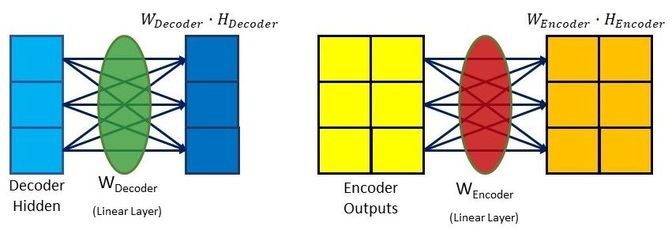

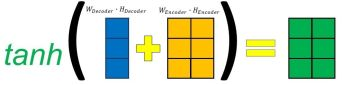&emsp; &emsp; &emsp; &emsp;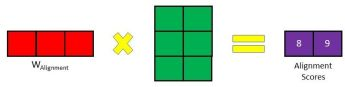

*Note: As there is no previous hidden state or output for the first decoder step, the last encoder hidden state and a Start Of String (<SOS>) token can be used to replace these two, respectively.*

In [2]:
class BahdanauDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, drop_prob=0.1):
        super(BahdanauDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.drop_prob = drop_prob
        
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        
        self.fc_hidden = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.fc_encoder = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.weight = nn.Parameter(torch.FloatTensor(1, hidden_size))
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.drop_prob)
        self.lstm = nn.LSTM(self.hidden_size * 2, self.hidden_size, batch_first=True)
        self.classifier = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, inputs, hidden, encoder_outputs):
        encoder_outputs = encoder_outputs.squeeze()
        # Embed input words
        embedded = self.embedding(inputs).view(1, -1)
        embedded = self.dropout(embedded)
        
        # Calculating Alignment Score
        x = torch.tanh(self.fc_hidden(hidden[0]) + self.fc_encoder(encoder_outputs))
        alignment_score = x.bmm(self.weight.unsqueeze(2))
        
        # Softmaxing alignment scores to get Attention weights
        attn_weights = F.softmax(alignment_score.view(1. -1), dim=1)
        
        # Multiplying the Attention weights with encoder outputs to get the context vector
        context_vector = torch.bmm(attn_weights.unsqueeze(0),
                                   encoder_outputs.unsqueeze(0))
        
        # Concatenating context vector with embedded input word
        output = torch.cat((embedded, context_vector[0]), 1).unsqueeze(0)
        # Passing the concatenated vector as input to LSTM cell
        output, hidden = self.lstm(output, hidden)
        # Passing the LSTM output through a Linear layer acting as a classifier
        output = F.log_softmax(self.classifier(output[0]), dim=1)
        return output, hidden, attn_weights

### 3. Softmaxing the Alignment Scores

After generating the alignment scores vector in the previous step, we can then apply a softmax on this vector to obtain the attention weights. The softmax function will cause the values in the vector to sum up to 1 and each individual value will lie between 0 and 1, therefore representing the weightage each input holds at that time step.

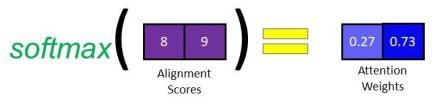

$$a_{ti}=align(y_t,x_i)=\frac{exp(score(s_{t-1},h_i))}{\sum_{i'=1}^{n} exp(score(s_{t-1},h_{i'}))}$$

how well $y_t$ and $x_i$ are aligned.

### 4. Calculating the Context Vector

Now we can generate the context vector by doing an element-wise multiplication of the attention weights with the encoder outputs. 其中 $c_i$ 取决于 encoder map the input sequence的annotations $(h_1,...,h_{T_x})$, 由annotation vector 加权得到 $c_t=\sum_{i=1}^{n}\alpha_{t,i}h_i$ ; context vector for output $y_t$

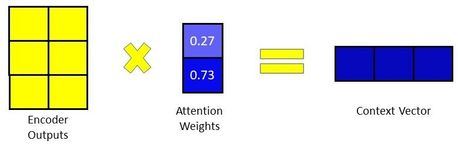

### 5. Decoding the Output

The context vector we produced will then be concatenated with the previous decoder output. It is then fed into the decoder RNN cell to produce a new hidden state and the process repeats itself from step 2. The final output for the time step is obtained by passing the new hidden state through a Linear layer, which acts as a classifier to give the probability scores of the next predicted word.

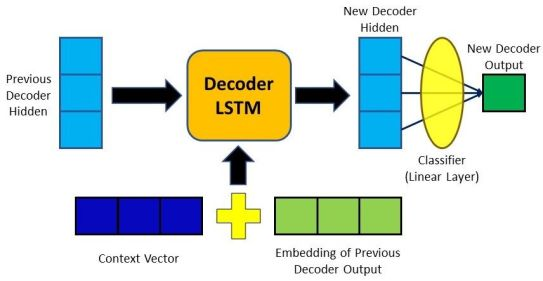

### 6. Attention Plot

![IMG_1842.PNG](attachment:99fa71ec-2f0e-4752-9c94-1a92b0275161.PNG)

The yellow and green shades suggest higher attention weights to the corresponding words in the source sequence in the prediction of the word of the target sequence.

### 7. BLEU Score

BLEU is a metric for evaluating a generated sentence to a reference sentence. A perfect match results in a score of 1.0, whereas a perfect mismatch results in a score of 0.0.

## Luong Attention

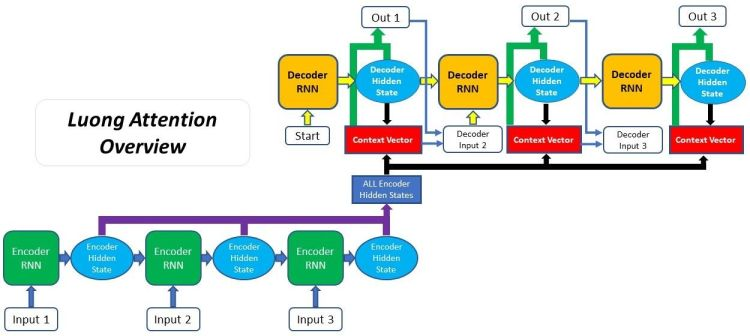

### 1. Producing the Encoder Hidden State

Same as Bahdanau Attention.

### 2. Decoder RNN

Unlike in Bahdanau Attention, the decoder in Luong Attention uses the RNN in the first step of the decoding process rather than the last. The RNN will take the hidden state produced in the previous time step and the word embedding of the final output from the previous time step to produce a new hidden state which will be used in the subsequent steps.

In [3]:
class LuongDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, attention, n_layers=1, drop_prob=0.1):
        super(LuongDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.drop_prob = drop_prob
        
        # The Attention Mechanism is defined in a seperate class
        self.attention = attention
        
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.dropout = nn.Dropout(self.drop_prob)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size)
        self.classifier = nn.Linear(self.hidden_size * 2, self.output_size)
        
    def forward(self, inputs, hidden, encoder_outputs):
        # Embed input words
        embedded = self.embedding(inputs).view(1, 1, -1)
        embedded = self.dropout(embedded)
        
        # Passing previous output word(embedded) and hidden state into LSTM Cell
        lstm_out, hidden = self.lstm(embedded, hidden) 

Luong Attention 基于 Bahdanau Attention，根据是否全部使用所有encoder outputs分为两种: global attention、local attention。

it is computationally less expensive than the global model or the soft attention; at the same time, unlike the hard attention, the local attention is differentiable almost everywhere, making it easier to implement and train.2 Besides, we also examine various alignment functions for our attention-based models.

Luong在encoder-decoder模型中使用的是两层单向循环神经网络且门控单元为LSTM，模型图如下。

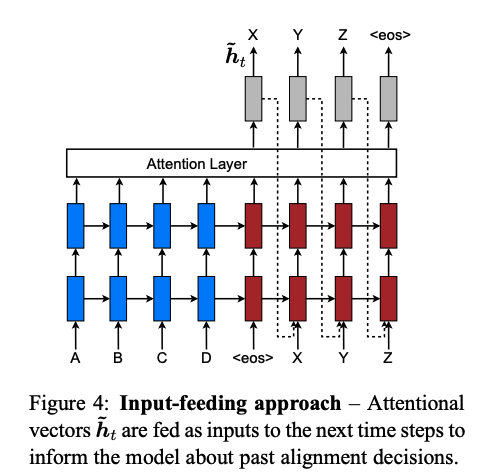

观察上图我们发现，encoder的最后时刻的hidden state $h_t$ 没有进行任何转换，直接送入到decoder中，所以encoder和decoder中的隐藏神经元数目是一样的，我们暂时设置为n,这也是Bahdanau和Luon提出Attention机制的区别之一。
